In [2]:
library(brms)
library(tidyverse)
library(parallel)

# Model description

Similar to voxelwise analysis of insula:

***Amygdala.*** 167 voxels of left amygdala were clustered into 6 sub-ROIs and 176 voxels of right amygdala were clustered into 6 sub-ROIs. Because the amygdala masks are much smaller than insula masks, hemisphere (R, L) to be considered as a grouping variable.

The model for given time window $p$ for amygdala then can be expressed in terms of a linear mixed effect model notation (lme-like) as:

$$
\Delta_{s,h,r,v} \sim 1 + (1|\text{Sub}) + (1|\text{Hem}) + (1|\text{ROI}) + (1|\text{VOX})
$$


Based on the distribution of summarized-estimated activation, the full model in the notation of \citet{mcelreath2018statistical} is:
$$
\Delta_{s,h,r,v} \sim \text{Student t}(\nu, \mu_{s,h,r,v},\sigma^{2})
$$

and,

$$
\mu_{s,h,r,v} = \alpha + \alpha_{\text{subj}[s]} + \alpha_{\text{hem}[h]} + \alpha_{\text{roi}[r]} + \alpha_{\text{voxel}[v]}
$$

where,

$$
\alpha_{j} \sim \text{student} (\nu_{j}, 0, \sigma_{j}^2), \quad j \in \{\text{subj, hem, roi, voxel}\}
$$

***Priors.*** The priors were defined similar to BML of ROI-level analysis expect for all degrees of freedom. The shortage of data in a group of ROI or voxel among subjects required more iterations in MCMC or more informative priors of these parameters, which was also suggested by the simulations based on the current dataset. Therefore, the priors were employed as:
$$\alpha \sim \text{Student t}(3, \mu_{y}, 2.5)$$
$$\nu \sim \text{Gamma}(3.325, 0.5)$$
$$\nu_{j} \sim \text{Gamma}(3.325, 0.5)$$
$$\sigma \sim \text{Half Student}(3, 0, 2.5)$$
$$\sigma_{j} \sim \text{Half Student}(3, 0, 2.5)$$
notice that $\mu_{y}$ is the sample mean of $\Delta_{s,h,r,v}$

Similarly, posterior distribution of the effect of trial is given by:

$$
p_{\text{trial}, [i,h,r,v]} = p_{\alpha, [i]} + \sum_j^{j \in \mathbb{V}}p_{\alpha_{j, [i]}}
$$

where,
* $\mathbb{V} =\{\text{hem}[h], \text{roi}[r], \text{voxel}[v]\}$
* $p_{\alpha, [i]}$: posterior sample of fixed intercept $\alpha$ at $i$th iteration
* $p_{\alpha_{j, [i]}}$: posterior sample of random intercept $j \in \mathbb{V}$ at $i$th iteration

And the $P+$ values were obtained as the same with ROI-level analysis.

# Extract posteriors

In [3]:
# Load the BML output (.RData)
# For amygdala, there are only 2 models: left and right
# Please select desired model by assign following variables
# phase: early or late
phase <- 'early'

respath <- paste0('results_offset/amygdala_', phase, '/')


load(paste0(respath, "amygdala_", phase, ".RData"))

In [4]:
ls()

[1] "chains"     "dataTable"  "df"         "fm"         "iterations"
 [6] "mod"        "modelForm"  "nfigs"      "ns"         "phase"     
[11] "priorRBA"   "project"    "respath"    "SCALE"      "stan_code"

In [5]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

In [6]:
write.table(as.data.frame(aa), file=paste0(respath, 'POP.txt'), sep='\t',
            col.names = TRUE, row.names = FALSE)

In [7]:
for (col in colnames(aa)){
    if (col == "Intercept"){
        hem_eff <- data.frame(bb[['Hem']][,,col])
        write.table(hem_eff, paste0(respath,'HEM_',col,'.txt'), sep='\t',
                    col.names = TRUE, row.names = FALSE)
        
        roi_eff <- data.frame(bb[['ROI']][,,col])
        write.table(roi_eff, paste0(respath,'ROI_',col,'.txt'), sep='\t',
                    col.names = TRUE, row.names = FALSE)
        
        vox_eff <- data.frame(bb[['VOX']][,,col])
        write.table(vox_eff, paste0(respath,'VOX_',col,'.txt'), sep='\t',
                    col.names = TRUE, row.names = FALSE)
    }
}

In [8]:
# Shows the summary of the model
cat(capture.output(summary(fm)), sep = '\n', append = TRUE)

Warning message:
“There were 123 divergent transitions after warmup. Increasing adapt_delta above  may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: diff ~ 1 + (1 | gr(Subj, dist = "student")) + (1 | gr(Hem, dist = "student")) + (1 | gr(ROI, dist = "student")) + (1 | gr(VOX, dist = "student")) 
   Data: dataTable (Number of observations: 35810) 
Samples: 4 chains, each with iter = 30000; warmup = 20000; thin = 1;
         total post-warmup samples = 40000

Group-Level Effects: 
~Hem (Number of levels: 2) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df                6.85      3.64     1.80    15.65 1.00    19158    14534
sd(Intercept)     0.62      0.95     0.01     3.21 1.00     8492    14768

~ROI (Number of levels: 12) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df                6.91      3.63     1.88    15.67 1.00     4699     5789
sd(Intercept)     0.12      0.04     0.06     0.21 1.00     8419     9478

~Subj (Number of levels: 109) 
              Estimate Est.Error l-95% CI u-95% 

# Diagnosis

Warning message:
“Removed 2043268 rows containing non-finite values (stat_density).”
Warning message:
“Removed 2116 rows containing non-finite values (stat_density).”


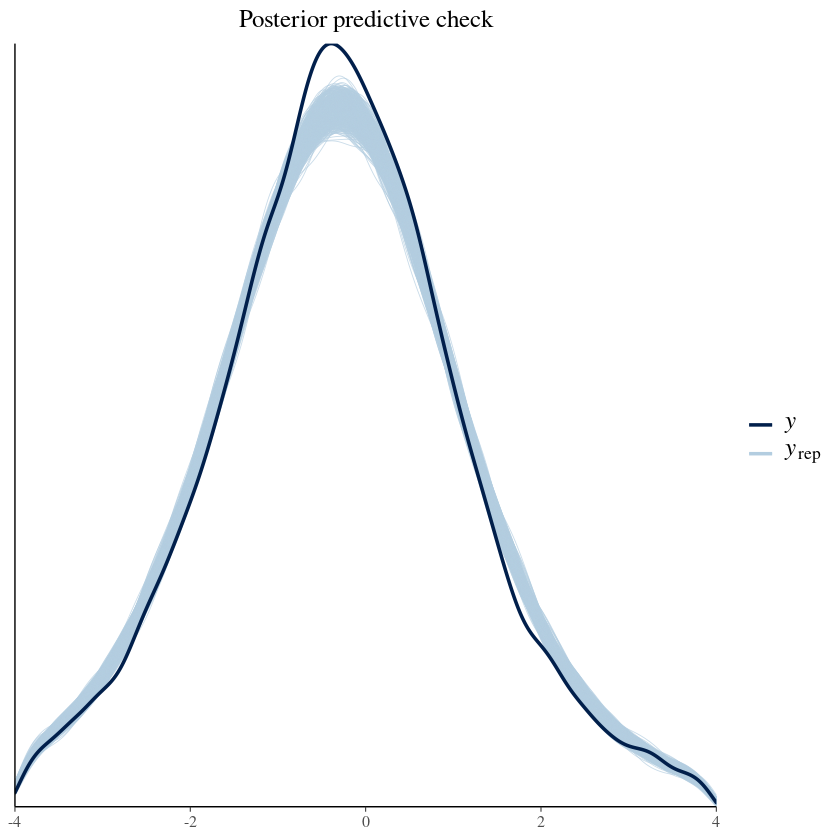

In [9]:
# Posterior predictive check
pp_check(fm, nsamples = 1000) + 
    xlim(c(-4, 4)) + 
    theme(plot.title = element_text(size = 15, hjust = 0.5), 
          legend.text = element_text(size = 15)) + 
    ggtitle("Posterior predictive check")